In [1]:
import os
import pandas as pd

from qiskit.circuit import QuantumCircuit
import optuna
import qtpu
from qtpu.compiler.terminators import reach_num_qubits
from qtpu.compiler.compiler import find_least_cost_trial, trial_to_circuit

from benchmark._plot_util import *

In [2]:
from benchmark.ansatz import qaoa1, qaoa2, generate_ansatz
from benchmark.util import get_info, append_to_csv
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from IPython.display import display
from optuna.visualization.matplotlib import plot_pareto_front


CSV = "tradeoff100.csv"

overheads = [1e5, 1e6, 1e7, 1e8, 1e9]

benchmarks = {
    "qml": generate_ansatz("zz", 100, 2),
    "qaoa1": qaoa1(7, 10, 2),
    "qaoa2": qaoa2(7, 10, 2),
    "vqe": generate_ansatz("linear", 100, 2),
}


results = {}

for name, bench in benchmarks.items():
    studies = []
    for overhead in overheads:
        study = qtpu.compiler.hyper_optimize(
            bench, max_cost=overhead, n_trials=200, choose_leaf_methods=["qubits"], show_progress_bar=True, 
        )
        studies.append(study)

        for trial in study.best_trials:
            trial = trial_to_circuit(trial)
            append_to_csv(CSV, {"name": name, "overhead": overhead, **get_info(trial)})

    results[name] = studies



    # append_to_csv(CSV, {"name": name, "overhead": overhead, **info})

ImportError: cannot import name 'generate_ansatz' from 'benchmark.ansatz' (/home/di75piq/qtpu/benchmark/ansatz.py)

In [2]:
def get_pareto_front(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    df = df.sort_values(x)
    pareto_front = df.copy()
    pareto_front[y] = df[y].cummin()
    pareto_front = pareto_front.drop_duplicates(y)
    return pareto_front

In [19]:
def plot(df, ax, y="esp"):
    df1 = get_pareto_front(df, "qtpu_cost_log10", y)
    df2 = get_pareto_front(df, "ckt_cost_log10", y)

    # x = "qtpu_cost_log10"

    # normalize x and y to be between 0 and 1
    df1["qtpu_cost_log10"] = (df1["qtpu_cost_log10"] - df1["qtpu_cost_log10"].min()) / (
        df1["qtpu_cost_log10"].max() - df1["qtpu_cost_log10"].min()
    )
    df1[y] = (df1[y] - df1[y].min()) / (df1[y].max() - df1[y].min())
    df2["ckt_cost_log10"] = (df2["ckt_cost_log10"] - df2["ckt_cost_log10"].min()) / (
        df2["ckt_cost_log10"].max() - df2["ckt_cost_log10"].min()
    )
    df2[y] = (df2[y] - df2[y].min()) / (df2[y].max() - df2[y].min())

    # get distances to (x, y) = (0, 0)
    df1["dist"] = (df1["qtpu_cost_log10"] ** 2 + df1[y] ** 2) ** 0.5
    df2["dist"] = (df2["ckt_cost_log10"] ** 2 + df2[y] ** 2) ** 0.5

    print("dist", df2["dist"].min() / df1["dist"].min())

    df1.plot(x="qtpu_cost_log10", y=y, style="o-", ax=ax, label="QTPU")
    df2.plot(x="ckt_cost_log10", y=y, style="^--", ax=ax, label="QAC")
    ax.plot(0, 0, "y*", markersize=15)
    return df2["dist"].min() / df1["dist"].min()

dist 0.27687763357190426
dist 0.7856493143813634
dist 0.45175082911435044
dist 0.6204942475861018
0.53369300616343


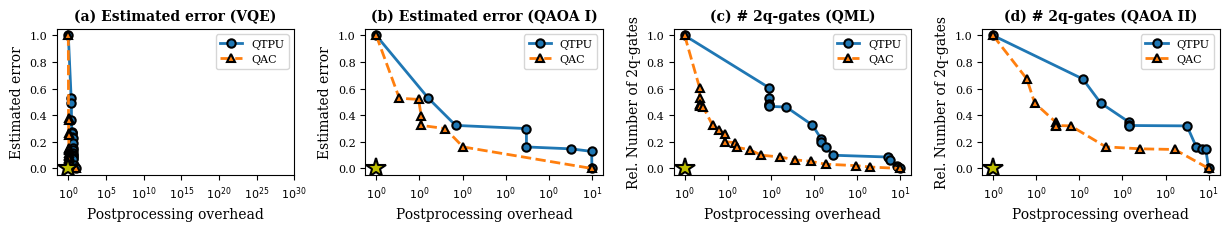

In [20]:
names = ["vqe", "qml", "qaoa1", "qaoa2"]
CSV = "results/tradeoff100.csv"
df = pd.read_csv(CSV)
df["esp"] = 1 - df["esp"]

df["num_2q"] = df["num_2q"] / df["base_num_2q"]
df["max_qubits"] = df["max_qubits"] / 100
dfs = (
    df[df["name"] == "vqe"],
    df[df["name"] == "qml"],
    df[df["name"] == "qaoa1"],
    df[df["name"] == "qaoa2"],
)


fig, axes = plt.subplots(1, 4, figsize=(15, 1.9))
fig.subplots_adjust(wspace=0.3)

# space between the plots 1 and 2


# axes[0].sharey(axes[1])
# axes[2].sharey(axes[3])


# share y between the first two plots


titles = ["QML", "QAOA II"]


axes[0].set_ylabel("Estimated error")

import numpy as np

print(
    np.mean(
        [
            plot(dfs[0], axes[0]),
            plot(dfs[2], axes[1]),
            plot(dfs[1], axes[2], "num_2q"),
            plot(dfs[3], axes[3], "num_2q"),
        ]
    )
)

axes[0].set_title("(a) Estimated error (VQE)", fontweight="bold", color="black")
axes[1].set_title("(b) Estimated error (QAOA I)", fontweight="bold", color="black")

axes[2].set_title("(c) # 2q-gates (QML)", fontweight="bold", color="black")
axes[3].set_title("(d) # 2q-gates (QAOA II)", fontweight="bold", color="black")

axes[2].set_xlabel("Postprocessing overhead")
axes[3].set_xlabel("Postprocessing overhead")

axes[2].set_ylabel("Rel. Number of 2q-gates")

axes[3].set_ylabel("Rel. Number of 2q-gates")
axes[1].set_ylabel("Estimated error")

axes[0].set_xlabel("Postprocessing overhead")
axes[1].set_xlabel("Postprocessing overhead")

# for i, (title, ax, df) in enumerate(zip(titles, axes.flat, dfs)):
#     plot(df, ax)
#     ax.set_title(f"({str(chr(97 + i))}) {title}", fontweight="bold")
#     ax.set_xlabel("log10(cost)")

axes[0].set_xlim(-1.5, 30)


def log_tick_formatter(val, pos):
    return f"$10^{{{int(val)}}}$"


from matplotlib.ticker import FuncFormatter

axes[2].xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
axes[3].xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
axes[0].xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
axes[1].xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

# replace the ticks with 10^x

In [20]:
fig.savefig("tradeoff100.pdf", bbox_inches="tight")

In [ ]:
get_pareto_front(df, "qtpu_cost_log10", "esp").plot(x="qtpu_cost_log10", y="esp", style="o-")

/tmp/ipykernel_563331/2600836115.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  plot_pareto_front(study, target_names=["qtpu_cost_log10", "num_2q"])


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='qtpu_cost_log10', ylabel='num_2q'>

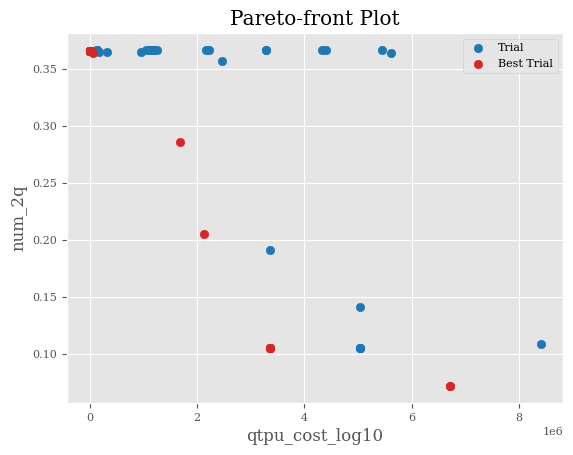

In [ ]:
plot_pareto_front(study, target_names=["qtpu_cost_log10", "num_2q"])

<Axes: xlabel='qtpu_cost_log10', ylabel='num_2q'>

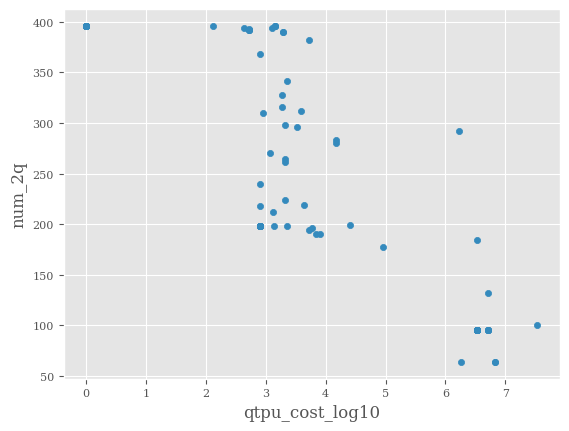

In [ ]:
df.plot(x="qtpu_cost_log10", y="num_2q", kind="scatter")

<Axes: xlabel='cost', ylabel='num_2q'>

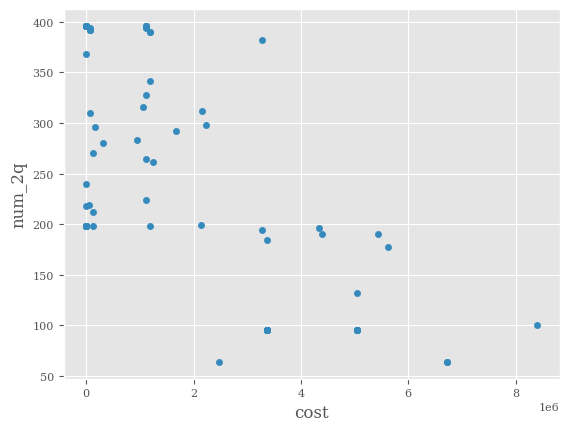

In [ ]:
df.plot(x="cost", y="num_2q", kind="scatter")

      calc_cost  qtpu_cost_log10  ckt_cost_log10  num_qpds  num_subcircuits  \
192         0.0         0.000000        0.000000         0                1   
193         0.0         0.000000        0.000000         0                1   
194         0.0         0.000000        0.000000         0                1   
195   8399376.0         7.531357       20.166992        24                7   
196         0.0         0.000000        0.000000         0                1   
..          ...              ...             ...       ...              ...   
270  16797456.0         7.226622       35.986843        44               12   
271  18477072.0         7.268008       39.136590        48               13   
272   5040144.0         6.703915       13.772639        16                5   
273   3360528.0         6.527946       10.541935        12                4   
274  13438224.0         7.129730       29.676203        36               10   

     num_instances  num_2q  max_qubits  depth    es

<Axes: xlabel='qtpu_cost_log10'>

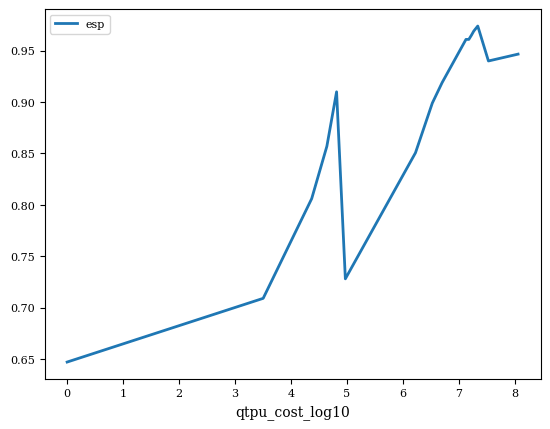

In [ ]:
df = pd.read_csv(CSV)

import numpy as np

df = df[df["name"] == "qml"].drop(columns=["name"])
print(df)
df1 = df.groupby("qtpu_cost_log10").mean().sort_index()
# df1["qtpu_cost"] = np.log(df1["qtpu_cost"])
# df1
# plot the df1 
fig, ax = plt.subplots()

df1.plot.line(ax=ax, y="esp")

# df2 = df.groupby("ckt_cost").mean().reset_index()
# df2["ckt_cost"] = np.log(df2["ckt_cost"])
# df2.plot.scatter(ax=ax, x="ckt_cost", y="esp")
# ax.set_xscale("log")

In [ ]:
def plot_pareto_front(study: optuna.Study, ax: plt.Axes) -> None:
    trials = set(tuple(trial.values) for trial in study.trials)
    best_trials = sorted(
        set(tuple(trial.values) for trial in study.best_trials),
        key=lambda x: (x[0], -x[1]),
    )
    non_optimal_trials = trials - set(best_trials)

    ax.plot(
        [vals[0] for vals in non_optimal_trials],
        [vals[1] for vals in non_optimal_trials],
        "x",
        # markeredgewidth=2,
        markersize=4,
        markeredgecolor="black",
        label="Non-optimal",
    )
    ax.plot(
        [vals[0] for vals in best_trials],
        [vals[1] for vals in best_trials],
        "o--",
        label="Pareto optimal",
        # color="red",
    )
    
        
    ax.set_xlabel("Contraction Cost")
    ax.set_ylabel("Success")

In [ ]:
# optuna.visualization.matplotlib.plot_contour(study, target=lambda t: t.values[1], params=["compress", "max_cost"])
# studies = studies[:1]
fig, axes = plt.subplots(1, len(studies), figsize=(5.5, 2))
axes = [axes] if len(studies) == 1 else axes
for ax, study in zip(axes, studies):
    plot_pareto_front(study, ax)
# ax.set_xscale("log")
# ax.set_xlim(-10000, 20000)
fig;

NameError: name 'studies' is not defined

In [ ]:
axes[0].set_ylabel("Max. Circuit Size")
axes[0].set_title("")
# set xlim to 4e9
axes[0].set_xlim(-.2e9, 3.5e9)

fig.set_figwidth(4.5)

fig.tight_layout()
fig.savefig("pareto.pdf", bbox_inches="tight")